# Augmentation and Transfer Learning

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import *

## Augmentation

Wir werden erstmal ein paar Augmentation Möglichkeiten ansehen, dann werde wir diese Methode auf unsere Daten probieren.

### Ein paar Möglichkeiten

Wir werden jetzt verschiedenen Funktionen, die für Augmentation benutzt sein können, uns ansehen. Es ist nur einen kleinen Auswahl an was möglich ist. Für mehreren Möglichkeiten: 'https://docs.fast.ai/vision.transform.html'

Lade hoch deine liebslingstes Bild. Da werden wir die Augmentation Möglichkeiten probieren. Die `plot_f` funktion zeigt 8 Bilder, die mit den gewählte Transformation ver grössert war.

*Bermerkung: am besten keine symmetrische Musterbild hochladen, um die Effekten von Augmentation Rate besser zu sehen*

In [3]:
def get_ex(): return open_image('datasets/tableware/mug/mug_6.jpg')

tfms = get_transforms()
def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

#### Using get_transforms()

Die `get_transforms()` Funktion stellt mehrere Transformation bereit, dass man auch kombinieren kann. Ersmal schauen wir und eine reguläre "Flip" Transformation.

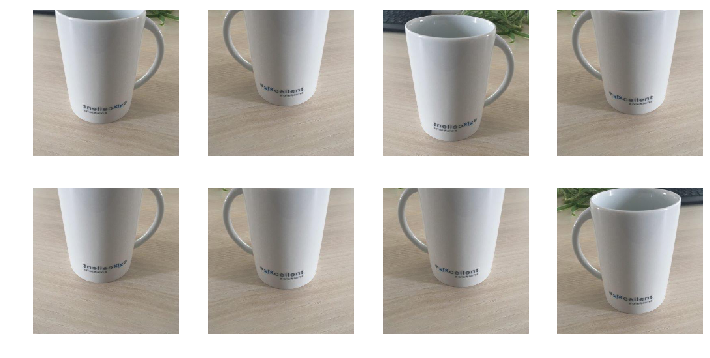

In [4]:
tfms = get_transforms(do_flip=True, max_rotate=0, max_zoom=0, max_lighting=0, max_warp=0)
plots_f(2, 4, 12, 6, size=224, padding_mode='zeros')

Dann können wir auch die anderen Parametern ändern um die Bildermenge mit mehreren Möglichkeiten und anderen Transformationen vergrössert zu können: Rotation, Zoom, Beleuchtung und Vervormung

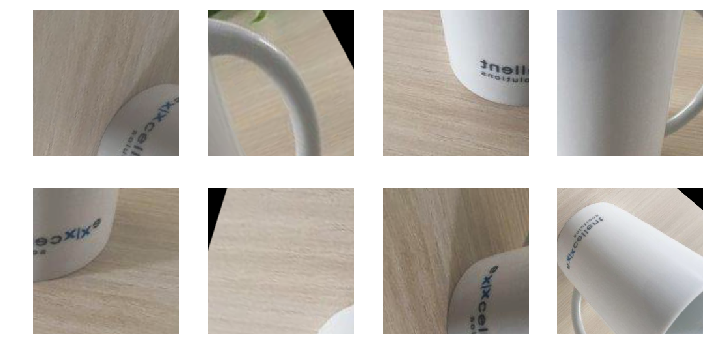

In [5]:
tfms = get_transforms(do_flip=True, max_rotate=180, max_zoom=5, max_lighting=0.2, max_warp=0, p_lighting=1)
plots_f(2, 4, 12, 6, size=224, padding_mode='zeros')

Es muss immer beachtet, was für Transformationen erlaubt man. Abhängig von die Parametern können blöde Bilder ankommen, die icht mehr zu tun haben mit den erste Objekt. In den Bild unten merkt man schon (mit die oberen Parameter generiert), dass die 3. Bilder auf der unteren Reihe kein Sinn macht: auf diese Bild steht keine Tasse mehr, sondern nur den Tisch... Außer die Bilder, die in der erste Spalte liegen, kann man sich nachfragen, wie die Bilder für unsere Zwecke relevant sind.

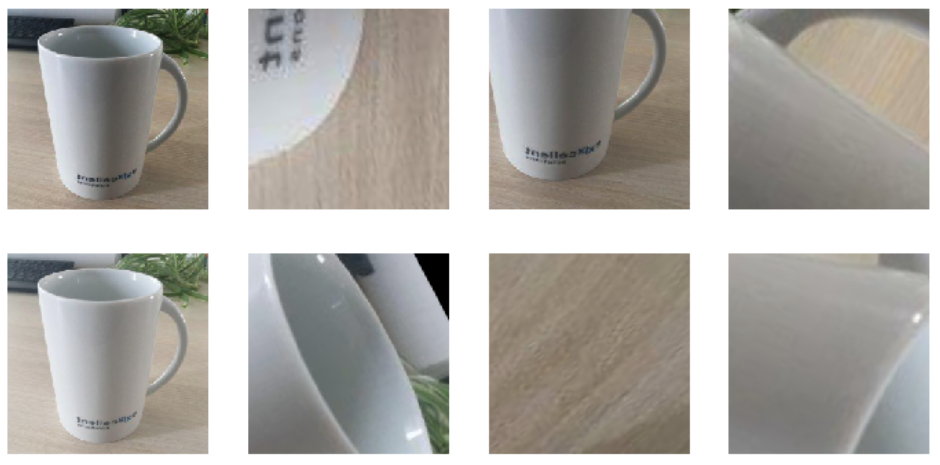

In [6]:
img_notOk = open_image('images/image_not_ok.PNG')
img_notOk

#### Using zoom_crop()

Die `zoom_crop()` Funktion kann nur die Bilder vergrossern und cropen.

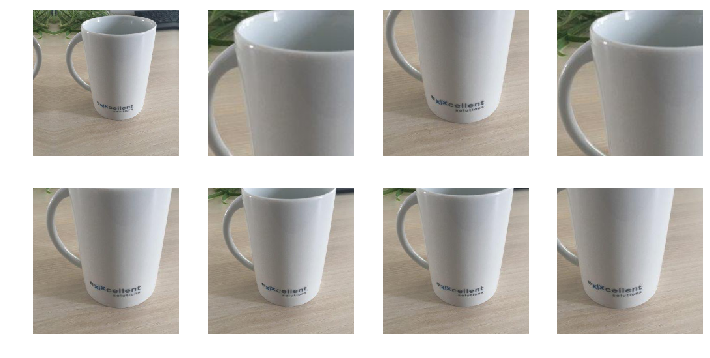

In [7]:
tfms = zoom_crop(scale=(0.75,2), do_rand=True)
plots_f(2, 4, 12, 6, size=224)

#### Using rand_resize_crop()

Die `rand_resize_crop()` Funktion kann die Bildern vergrössern und cropen.

Diese Transformation ist eine Implementierung des Hauptansatzes, der für fast alle erfolgreichen `Imagenet` Anwendungen seit 2013 verwendet wird. Es ist basiert auf Andrew Howard article: Some Improvements on Deep Convolutional Neural Network Based Image Classification.

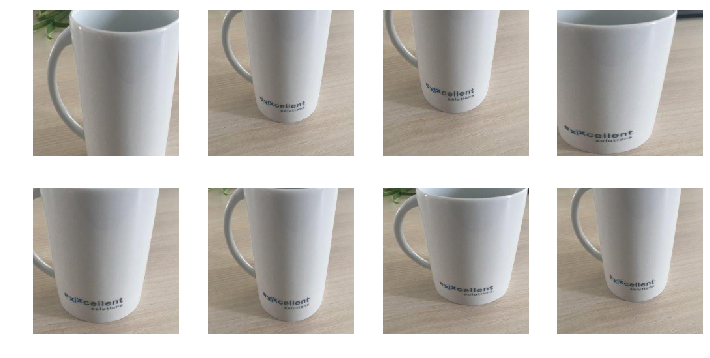

In [8]:
tfms = rand_resize_crop(224)
plots_f(2, 4, 12, 6, size=224)

### Ergebnisse mit und ohne Augmentation Rate

Wir werden hier mit die Blättern weiter machen.

In [9]:
path = Path('datasets/tableware')

In [10]:
np.random.seed(1337)
data = ImageDataBunch.from_folder(path, valid_pct=0.2, bs=10,
                                  size=224).normalize(imagenet_stats)

In [11]:
learn_withoutAR = cnn_learner(data, models.resnet34, metrics=error_rate)
learn_withoutAR.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.411383,0.442689,0.133333,00:05
1,0.732460,0.206619,0.066667,00:01
2,0.484456,0.093074,0.000000,00:01
3,0.366699,0.077054,0.000000,00:01


Mit Augmentation rate: wir benutzen den Parameter `ds_tfms`

In [12]:
np.random.seed(1337)
data_withAR = ImageDataBunch.from_folder(path, valid_pct=0.2, bs=10,
                                         ds_tfms=get_transforms(do_flip=True, max_rotate=10, max_zoom=0.1, max_warp=0.1, max_lighting=0.2),
                                         size=224).normalize(imagenet_stats)

In [13]:
learn_withAR = cnn_learner(data_withAR, models.resnet34, metrics=error_rate)
learn_withAR.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.344958,0.498992,0.133333,00:01
1,0.814363,0.164124,0.066667,00:01
2,0.519281,0.112139,0.066667,00:01
3,0.392364,0.097117,0.066667,00:01


Probieren wir es jetzt mit die Tableware. Wie sehen die Ergebnisse aus?

*Bemerkung* : es kann sein, dass die Augmentation nicht hilft, unsere Ergebnisse besser zu machen. Zum Beispiel, wenn die gewählte Transformation, die man gewählt hat, nicht gut sind.

## Transfer Learning

Wir werden den Beispiel mit die Gläser wieder benutzen. Da hätten wir gute Ergebnisse bekommen, mit einem pretrained CNN model.

Erst muss man die Daten wieder vorbereiten

In [14]:
path = Path('datasets/tableware')
np.random.seed(1337)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, bs=10,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Dann den Model auf unseren Daten benutzen, erstmal für mit eine Vortraining (`pretrained=True`) ie mit Transfer Learning. Wenn man nichts spezifiziert, ist es per Default mit Vortraining genommen.

In [15]:
learn_withTL = cnn_learner(data, models.resnet34, pretrained=True, metrics=error_rate)
learn_withTL.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.190686,0.606555,0.133333,00:01
1,0.672422,0.196273,0.066667,00:01
2,0.450387,0.118156,0.000000,00:01
3,0.353339,0.088633,0.000000,00:01


Dann ohne Transfer Learning (`pretrained=False`)

In [16]:
learn_withoutTL = cnn_learner(data, models.resnet34, pretrained=False, metrics=error_rate)
learn_withoutTL.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.211120,1.165441,0.733333,00:01
1,1.265399,1.239003,0.733333,00:01
2,1.301541,0.962086,0.466667,00:01
3,1.233631,1.072441,0.533333,00:01


Mit diese Ergebnisse merken wir schon, dass die Ergebnisse ohne Transfer Learning schlechter als mit sind. Wir können uns auch die Confusion Matrix ansehen.

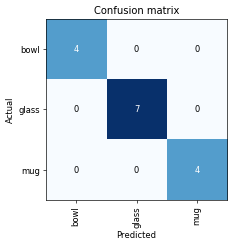

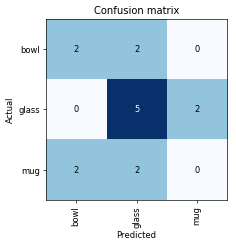

In [17]:
interp_withTL = ClassificationInterpretation.from_learner(learn_withTL)
interp_withTL.plot_confusion_matrix(figsize=(4,4), dpi=60)

interp_withoutTL = ClassificationInterpretation.from_learner(learn_withoutTL)
interp_withoutTL.plot_confusion_matrix(figsize=(4,4), dpi=60)

Mit dem gleichen Datensatz sind die Ergenisse viel zuverlässiger wenn das Model erst trainiert war.

*Bemerkung : Wenn man wir das gleiche Code wieder starten, bekommen wir nicht das gleiche Ergebnisse. Das kommt von unsere "random" Bildauswahl.*

### Unfreeze

Mit `unfreeze()` kann man die erste Schichten des models trainieren lassen.

In [18]:
learn_unfreeze = cnn_learner(data, models.resnet34, pretrained=True, metrics=error_rate)
learn_unfreeze.fit_one_cycle(4)

learn_unfreeze.unfreeze()
learn_unfreeze.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.279822,0.522705,0.000000,00:01
1,0.773650,0.092222,0.000000,00:01
2,0.537387,0.068727,0.000000,00:01
3,0.389530,0.072053,0.000000,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.171201,0.545102,0.200000,00:01
1,0.200397,0.257087,0.133333,00:01


*Bemerkung*: In diesem Fall sind die Ergebnise mit `unfreeze()` nicht besser geworden. Der Grund davon ist, dass unsere Datensatz klein ist. In den nächsten Stunden werden wir sehen, wie man den ersten Schichten richtig trianiert mit den *learning rate*.

## Hands on

1. Mit seinen eigenen Bilder probieren
    1. Welche Transformationen sind für mich interessant?
    2. Welche Werte soll ich für meine bilder wählen? 
2. Andere Augmentation Möglichkeiten von 'https://docs.fast.ai/vision.transform.html' probieren.
3. Augment dein Bilder und probier das aus ohne transfer learning. Vergleich die Ergebnisse (ohne augmentation, mit TL), (ohne aug, ohne TL), (mit aug, ohne TL), (mit aug, mit TL)